In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import functools
from attrdict import AttrDict
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
%matplotlib inline

In [24]:
# Plotting setup
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'cmu serif'

In [4]:
class DataSampler():
    def __init__(self, mean_1, mean_2, mean_3, std, device='cpu'):
        self.cluster1 = Normal(torch.tensor(mean_1, device=device), torch.tensor([std], device=device))
        self.cluster2 = Normal(torch.tensor(mean_2, device=device), torch.tensor([std], device=device))
        self.cluster3 = Normal(torch.tensor(mean_3, device=device), torch.tensor([std], device=device))
        self.device = device

    def sample(self, batch_size=128):
        counts = [batch_size // 3 + (1 if n < batch_size % 3 else 0)  for n in range(3)]
        random.shuffle(counts)
        n_c1, n_c2, n_c3 = counts
        
        x_c1 = self.cluster1.sample(torch.Size([n_c1])) # shp (M,2)
        y_c1 = torch.zeros(n_c1, dtype=int, device=self.device) # shp (M,)
        y_c1[:n_c1//2] = 1
    
        x_c2 = self.cluster2.sample(torch.Size([n_c2]))
        y_c2 = torch.zeros(n_c2, dtype=int, device=self.device) # shp (M,)

        x_c3 = self.cluster3.sample(torch.Size([n_c3]))
        y_c3 = torch.ones(n_c3, dtype=int, device=self.device) # shp (M,)
        
        x_all = torch.vstack((x_c1, x_c2, x_c3))
        y_all = torch.cat((y_c1, y_c2, y_c3))
        
        perm = torch.randperm(len(x_all))
        x_all = x_all[perm,:]
        y_all = y_all[perm]

        return x_all, y_all

In [5]:
class SyntheticExpert():
    '''Synthetic experts varying by correctness probability (only based on labels)'''
    def __init__(self, n_classes=2, p=0.95, device='cpu'):
        self.n_classes = n_classes
        self.p = p
        self.device = device

    def __call__(self, inputs, labels):
        batch_size = labels.size()[0]
        outs = [0] * batch_size
        for i in range(0, batch_size):
            coin_flip = np.random.binomial(1, self.p)
            if coin_flip == 1:
                outs[i] = labels[i].item()
            if coin_flip == 0:
                outs[i] = 1-labels[i].item() # anti-oracle
            
        return torch.tensor(outs, device=self.device)

In [6]:
def cross_entropy(outputs, m, labels, n_classes):
    batch_size = outputs.size()[0]
    rc = [n_classes] * batch_size # idx to extract rejector function
    outputs = -m * torch.log2(outputs[range(batch_size), rc]) - torch.log2(outputs[range(batch_size), labels])
    return torch.sum(outputs) / batch_size

In [7]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, labels):
        super().__init__()
        self.data, self.targets = inputs, labels
        self.targets = torch.asarray(self.targets, dtype=torch.int64)

    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])
        return img, target

    def __len__(self):
        return len(self.data)

def build_mlp(dim_in, dim_hid, dim_out, depth):
    act = functools.partial(nn.ReLU, inplace=True)
    if depth==1:
        modules = [nn.Linear(dim_in, dim_out)] # no hidden layers
    else: # depth>1
        modules = [nn.Linear(dim_in, dim_hid), act()]
        for _ in range(depth-2):
            modules.append(nn.Linear(dim_hid, dim_hid))
            modules.append(act())
        modules.append(nn.Linear(dim_hid, dim_out))
    return nn.Sequential(*modules)

class ClassifierRejectorWithContextEmbedder(nn.Module):
    def __init__(self, input_dim, num_classes, dim_hid=64, depth_embed=3, depth_rej=2, dim_embed_x=16):
        super(ClassifierRejectorWithContextEmbedder, self).__init__()
        self.embed_class = nn.Embedding(num_classes, dim_embed_x)
        self.embed_x = nn.Linear(input_dim, dim_embed_x)
        self.embed = build_mlp(dim_embed_x*3, dim_hid, dim_hid, depth_embed)
        self.clf = nn.Linear(dim_embed_x, num_classes) # linear classifier
        self.rej = build_mlp(dim_embed_x+dim_hid, dim_hid, 1, depth_rej)

    def forward(self, x, cntxt):
        '''
        Args:
            x : tensor [B,D]
            cntxt : AttrDict, with entries
                xc : tensor [E,Nc,D]
                yc : tensor [E,Nc]
                mc : tensor [E,Nc]
        '''
        n_experts = cntxt.xc.shape[0]
        x_embed = self.embed_x(x) # [B,Dx]
        logits_clf = self.clf(x_embed) # [B,K]
        logits_clf = logits_clf.unsqueeze(0).repeat(n_experts,1,1) # [E,B,K]
        embedding = self.encode(cntxt, x) # [E,B,H]
        x_embed = x_embed.unsqueeze(0).repeat(n_experts,1,1) # [E,B,Dx]
        packed = torch.cat([x_embed,embedding], -1) # [E,B,Dx+H]
        logit_rej = self.rej(packed) # [E,B,1]
        out = torch.cat([logits_clf,logit_rej], -1) # [E,B,K+1]
        out = F.softmax(out, dim=-1)
        return out

    def encode(self, cntxt, xt):
        n_experts = cntxt.xc.shape[0]
        batch_size = xt.shape[0]

        cntxt_xc = cntxt.xc.view((-1,) + cntxt.xc.shape[2:]) # [E*Nc,D]
        xc_embed = self.embed_x(cntxt_xc) # [E*Nc,Dx]
        xc_embed = xc_embed.view(cntxt.xc.shape[:2] + (xc_embed.shape[-1],)) # [E,Nc,Dx]

        yc_embed = self.embed_class(cntxt.yc) # [E,Nc,Dx]
        mc_embed = self.embed_class(cntxt.mc) # [E,Nc,Dx]

        out = torch.cat([xc_embed,yc_embed,mc_embed], -1) # [E,Nc,3*Dx]
        out = self.embed(out) # [E,Nc,H]
        embedding = out.mean(-2) # [E,H]
        embedding = embedding.unsqueeze(1).repeat(1,batch_size,1) # [E,B,H]

        return embedding

class ClassifierRejector(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ClassifierRejector, self).__init__()
        self.clf = nn.Linear(input_dim, num_classes)
        self.rej = nn.Linear(input_dim, 1)

    def forward(self, x):
        logits_clf = self.clf(x) # [B,K]
        logit_rej = self.rej(x) # [B,1]
        out = torch.cat([logits_clf,logit_rej], -1) # [B,K+1]
        out = F.softmax(out, dim=-1)
        return out

In [8]:
class ContextSampler():
    def __init__(self, data, n_cntx_pts=50, device='cpu'):
        '''data can be of type MyDataset or DataSampler'''
        self.n_cntx_pts = n_cntx_pts
        self.device = device

        self.is_dataloader = False
        if isinstance(data, MyDataset):
            self.dataloader = torch.utils.data.DataLoader(data, batch_size=self.n_cntx_pts, shuffle=True, drop_last=True)
            self.data_iter = iter(self.dataloader)
            self.is_dataloader = True
        else: # assumed to be DataSampler
            self.datasampler = data

    def _sample(self):
        if self.is_dataloader:
            try:
                data_batch = next(self.data_iter)
            except StopIteration:
                self.data_iter = iter(self.dataloader)
                data_batch = next(self.data_iter)
    
            input_all, target_all = data_batch
        else:
            input_all, target_all = self.datasampler.sample(self.n_cntx_pts)
        
        input_all, target_all = input_all.to(self.device), target_all.to(self.device)
        return input_all, target_all

    def sample(self, n_experts=1):
        # Not resample for multiple experts (at train-time)
        cntx = AttrDict()
        input, target = self._sample()
        cntx.xc = input.unsqueeze(0).repeat(n_experts,1,1)
        cntx.yc = target.unsqueeze(0).repeat(n_experts,1)
        return cntx
    
    def reset(self):
        if self.is_dataloader:
            self.data_iter = iter(self.dataloader)

In [9]:
def train_l2d(model, l2d_type='single'):
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.n_steps)

    for step in range(1, config.n_steps+1):
        model.train()
        
        input, target = data_sampler.sample(batch_size=config.train_batch_size)
        input, target = input.to(device), target.to(device)
    
        n_experts = len(experts_lst)

        if l2d_type == 'pop':
            expert_cntx = cntx_sampler_train.sample(n_experts=n_experts)
            
            # sample expert predictions for context
            exp_preds_cntx = []
            for idx_exp, expert in enumerate(experts_lst):
                preds = expert(expert_cntx.xc[idx_exp], expert_cntx.yc[idx_exp])
                exp_preds_cntx.append(preds.unsqueeze(0))
            expert_cntx.mc = torch.vstack(exp_preds_cntx)

            outputs = model(input,expert_cntx) # [E,B,K+1]
        else: # single
            outputs = model(input) # [B,K+1]
            outputs = outputs.unsqueeze(0).repeat(n_experts,1,1) # [E,B,K+1]
    
        loss = 0
        for idx_exp, expert in enumerate(experts_lst):
            m = expert(input, target)
            costs = (m==target).int()
            loss += cross_entropy(outputs[idx_exp], costs, target, n_classes) # loss per expert
        loss /= len(experts_lst)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    
        # print(f'Step: {step:3d}\t Loss {loss.item():.4f}')

        if step % config.eval_freq == 0:
            with torch.no_grad():
                model.eval()
                
                correct = 0
                correct_sys = 0
                exp = 0
                exp_total = 0
                total = 0
                real_total = 0
                clf_alone_correct = 0
                exp_alone_correct = 0
                losses = []
        
                is_rejection = []
                clf_predictions = []
                exp_predictions = []
        
                for (images, labels) in valid_loader:
                    images, labels = images.to(device), labels.to(device)
        
                    choice = random.randint(0, len(experts_lst)-1)
                    expert = experts_lst[choice]

                    if l2d_type == 'pop':
                        # sample expert predictions for context
                        expert_cntx = cntx_sampler_val.sample(n_experts=1)
                        exp_preds = expert(expert_cntx.xc.squeeze(0), expert_cntx.yc.squeeze())
                        expert_cntx.mc = exp_preds.unsqueeze(0)
        
                        outputs = model(images, expert_cntx).squeeze(0)
                    else: # single
                        outputs = model(images)
                    
                    clf_probs, clf_preds = outputs[:,:n_classes].max(dim=-1)
                    exp_probs = outputs[:,n_classes]
                    clf_predictions.append(clf_preds)
                    # defer if rejector logit strictly larger than (max of) classifier logits
                    # since max() returns index of first maximal value (different from paper (geq))
                    _, predicted = outputs.max(dim=-1)
                    is_rejection.append((predicted==n_classes).int())
                    
                    # sample expert predictions for evaluation data and evaluate costs
                    exp_pred = expert(images, labels)
                    m = (exp_pred==labels).int()
                    exp_predictions.append(exp_pred)
                    
                    loss = cross_entropy(outputs, m, labels, n_classes) # single-expert L2D loss
                    losses.append(loss.item())
                    
                    for i in range(0, len(images)):
                        r = is_rejection[real_total].item()
                        prediction = clf_predictions[real_total].item()
                        exp_prediction = exp_predictions[real_total].item()
                    
                        clf_alone_correct += (prediction == labels[i]).item()
                        exp_alone_correct += (exp_prediction == labels[i].item())
                        if r == 0:
                            total += 1
                            correct += (prediction == labels[i]).item()
                            correct_sys += (prediction == labels[i]).item()
                        if r == 1:
                            exp += (exp_prediction == labels[i].item())
                            correct_sys += (exp_prediction == labels[i].item())
                            exp_total += 1
                        real_total += 1
    
                cov = str(total) + str("/") + str(real_total)
                metrics = {"cov": cov, "sys_acc": 100 * correct_sys / real_total,
                            "exp_acc": 100 * exp / (exp_total + 0.0002),
                            "clf_acc": 100 * correct / (total + 0.0001),
                            "exp_acc_alone": 100 * exp_alone_correct / real_total,
                            "clf_acc_alone": 100 * clf_alone_correct / real_total,
                            "val_loss": np.average(losses)}
                to_print = ""
                for k,v in metrics.items():
                    if type(v)==str:
                        to_print += f"{k} {v} "
                    else:
                        to_print += f"{k} {v:.6f} "
                
                print(to_print)

In [10]:
config = AttrDict()
config.lr = 1e-2
config.train_batch_size = 128
config.n_steps = 500
config.n_cntx_pts = 25
config.eval_freq = 25
config.n_val_data = 1000 # validation happens in batches of 1
config.seed = 0

config.depth_embed = 3
config.depth_rej = 2

# 2D data
data_spec = {
    'mean_1':[1.3,1.3],
    'mean_2':[-1.1,-0.2],
    'mean_3':[-0.2,-1.1],
    'std':0.085
}
n_classes=2

# expert specifications (unchanged train & test time)
expert_correctness_probs = [0.01, 0.8, 0.95]

random.seed(config.seed)
np.random.seed(config.seed)
torch.manual_seed(config.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(config.seed)
    torch.cuda.manual_seed_all(config.seed)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
experts_lst = [SyntheticExpert(n_classes, p, device=device) for p in expert_correctness_probs]

In [13]:
data_sampler = DataSampler(**data_spec, device=device)

cntx_sampler_train = ContextSampler(data_sampler, config.n_cntx_pts, device=device)

val_data_trgt = MyDataset(*data_sampler.sample(config.n_val_data))
val_data_cntx = MyDataset(*data_sampler.sample(config.n_val_data))
cntx_sampler_val = ContextSampler(val_data_cntx, config.n_cntx_pts, device=device)

valid_loader = torch.utils.data.DataLoader(val_data_trgt, batch_size=1, shuffle=False)

In [14]:
model_pop = ClassifierRejectorWithContextEmbedder(input_dim=2, num_classes=2, depth_embed=config.depth_embed, depth_rej=config.depth_rej)
model_pop = model_pop.to(device)
print('L2D-Pop (NP) -- No. of parameters: {}'.format(sum(p.numel() for p in model_pop.parameters() if p.requires_grad)))

model_single = ClassifierRejector(input_dim=2, num_classes=2)
model_single = model_single.to(device)
print('single-L2D -- No. of parameters: {}'.format(sum(p.numel() for p in model_single.parameters() if p.requires_grad)))

L2D-Pop (NP) -- No. of parameters: 16819
single-L2D -- No. of parameters: 9


In [15]:
print('# single-L2D')
train_l2d(model_single, 'single')

# single-L2D
cov 590/1000 sys_acc 54.400000 exp_acc 56.341436 clf_acc 53.050838 exp_acc_alone 56.500000 clf_acc_alone 68.300000 val_loss 2.375567 
cov 487/1000 sys_acc 71.200000 exp_acc 59.259236 clf_acc 83.778217 exp_acc_alone 58.100000 clf_acc_alone 83.400000 val_loss 2.250846 
cov 772/1000 sys_acc 81.700000 exp_acc 57.894686 clf_acc 88.730558 exp_acc_alone 57.800000 clf_acc_alone 83.900000 val_loss 2.148733 
cov 758/1000 sys_acc 85.600000 exp_acc 61.156974 clf_acc 93.403682 exp_acc_alone 59.000000 clf_acc_alone 83.600000 val_loss 2.101978 
cov 786/1000 sys_acc 84.300000 exp_acc 56.542003 clf_acc 91.857495 exp_acc_alone 57.800000 clf_acc_alone 83.600000 val_loss 2.034640 
cov 737/1000 sys_acc 84.700000 exp_acc 58.174861 clf_acc 94.165523 exp_acc_alone 59.300000 clf_acc_alone 83.800000 val_loss 2.028978 
cov 749/1000 sys_acc 85.500000 exp_acc 60.956127 clf_acc 93.724954 exp_acc_alone 58.700000 clf_acc_alone 82.800000 val_loss 1.996467 
cov 736/1000 sys_acc 85.800000 exp_acc 61.742377 

In [16]:
print('# Train L2D-Pop (NP)')
train_l2d(model_pop, 'pop')

# Train L2D-Pop (NP)
cov 700/1000 sys_acc 90.500000 exp_acc 89.333274 clf_acc 90.999987 exp_acc_alone 57.000000 clf_acc_alone 83.300000 val_loss 1.716468 
cov 683/1000 sys_acc 91.200000 exp_acc 90.220763 clf_acc 91.654452 exp_acc_alone 54.600000 clf_acc_alone 83.400000 val_loss 1.595019 
cov 611/1000 sys_acc 88.800000 exp_acc 87.917693 clf_acc 89.361688 exp_acc_alone 59.000000 clf_acc_alone 83.400000 val_loss 1.667019 
cov 627/1000 sys_acc 91.200000 exp_acc 91.152766 clf_acc 91.228056 exp_acc_alone 60.600000 clf_acc_alone 83.400000 val_loss 1.675707 
cov 594/1000 sys_acc 89.400000 exp_acc 87.438381 clf_acc 90.740725 exp_acc_alone 58.800000 clf_acc_alone 83.300000 val_loss 1.662184 
cov 543/1000 sys_acc 89.200000 exp_acc 89.059042 clf_acc 89.318584 exp_acc_alone 60.700000 clf_acc_alone 83.100000 val_loss 1.696793 
cov 537/1000 sys_acc 90.100000 exp_acc 89.416808 clf_acc 90.688996 exp_acc_alone 61.700000 clf_acc_alone 83.000000 val_loss 1.696082 
cov 704/1000 sys_acc 90.500000 exp_acc 86

Expert p=0.95


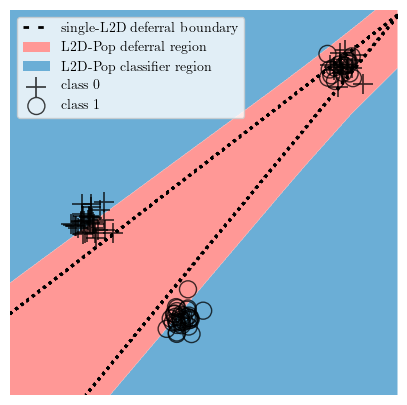

In [23]:
expert_idx = 2
print(f'Expert p={expert_correctness_probs[expert_idx]}')

# Construct context set
expert_cntx = cntx_sampler_train.sample(n_experts=len(experts_lst))
exp_preds_cntx = []
for idx_exp, expert in enumerate(experts_lst):
    preds = expert(expert_cntx.xc[idx_exp], expert_cntx.yc[idx_exp])
    exp_preds_cntx.append(preds.unsqueeze(0))
expert_cntx.mc = torch.vstack(exp_preds_cntx)

# Construct grid
h=0.005
mesh_x0, mesh_x1 = torch.meshgrid(torch.arange(-1.85,1.85, h), torch.arange(-1.85, 1.85, h))
grid = torch.vstack((mesh_x0.flatten(), mesh_x1.flatten())).T
grid = grid.to(device=device)

# Predictions on grid
with torch.no_grad():
    model_single.eval()
    model_pop.eval()
    outputs = model_single(grid) # [B,K+1]
    _, preds_single = outputs.max(dim=-1)
    outputs = model_pop(grid,expert_cntx) # [E,B,K+1]
    _, preds_pop_all = outputs.max(dim=-1)
# merge preds of either of two classes into 1
preds_pop_all[preds_pop_all==1] = 0
preds_pop_all[preds_pop_all==2 ] = 1
preds_single[preds_single==1] = 0
preds_single[preds_single==2 ] = 1

preds_pop_grid = preds_pop_all[expert_idx].detach().cpu().numpy()
preds_single_grid = preds_single.detach().cpu().numpy()

# Generate some data
n_data = 100
X, y = data_sampler.sample(n_data)
X = X.detach().cpu().numpy()
y = y.detach().cpu().numpy()

fig, ax = plt.subplots(1,1, figsize=(5,5))
scat_c0 = ax.scatter(X[y==0,0], X[y==0,1], facecolors='k', s=200, marker='+', linewidths=1.25, zorder=3, alpha=0.75)
scat_c1 = ax.scatter(X[y==1,0], X[y==1,1], edgecolors='k', fc='none', s=150, marker='o', linewidths=1, zorder=3, alpha=0.75)

mesh_x0 = mesh_x0.detach().cpu().numpy()
mesh_x1 = mesh_x1.detach().cpu().numpy()

cmap = mpl.colors.ListedColormap([mpl.cm.tab20c(1),mpl.cm.tab20(7)])

cntr_pop = ax.contourf(mesh_x0, mesh_x1, preds_pop_grid.reshape(*mesh_x0.shape), zorder=1, antialiased=True, cmap=cmap) # alpha=0.75
cntr_single = ax.contour(mesh_x0, mesh_x1, preds_single_grid.reshape(*mesh_x0.shape), zorder=2, linestyles=':', colors='k', linewidths=2)

ax.set_xticks([])
ax.set_yticks([])
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_visible(False)

cntr_single_leg,_ = cntr_single.legend_elements()
cntr_pop_leg,_ = cntr_pop.legend_elements()
ax.legend([cntr_single_leg[0], cntr_pop_leg[-1], cntr_pop_leg[0], scat_c0, scat_c1], \
          ['single-L2D deferral boundary', 'L2D-Pop deferral region', 'L2D-Pop classifier region', 'class 0', 'class 1'], \
          loc='upper left', frameon=True, fontsize=10)